In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
sns.set_palette('coolwarm')

### Read in data 

and bin to 100s sampling

In [2]:
X = np.genfromtxt('../data/ts_file.dat',skip_header=1).T

<ErrorbarContainer object of 3 artists>

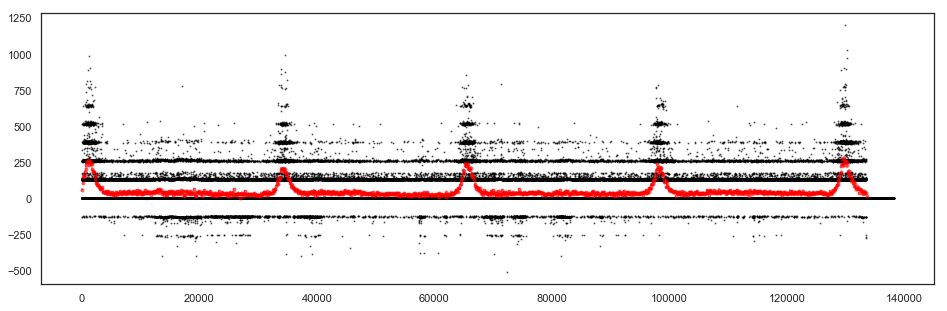

In [3]:
t,y,s=X
t -= t[0]
bins = np.r_[t.min()+50:t.max()+50:100]
ybins = np.zeros_like(bins)
indices = np.digitize(t,bins)
y[~np.isfinite(y)] = 0.0
for i in range(len(bins)):
    c = (indices == i)
    ybins[i] = y[c].sum()
l = ybins > 0
tbin = bins[l]
ybin = ybins[l]
sbin = np.sqrt(ybin)
plt.figure(figsize=(16,5))
plt.plot(t,y*100,'k.',ms=2,alpha=0.5)
plt.errorbar(tbin,ybin,yerr=sbin,fmt='r.',alpha=0.5)

### Functions to fit Gaussian pulses, with or without GP

#### <font color=red>TBD: test assumption of Gaussian pulses</font>

In [10]:
from scipy.optimize import minimize
from george import kernels, GP
import emcee, corner

In [4]:
def gauss(p, t):
    amp, mu, sig, dc = p
    return dc + amp * np.exp(-(t-mu)**2/2/sig**2)

def chi2_gauss(p, t, y, e):
    m = gauss(p, t)
    r = y - m
    return ((r/e)**2).sum()

In [32]:
def nll_gauss_gp(p, t, y, e, gp, xfac):
    gp.set_parameter_vector(p[4:])
    x = t * xfac
    try:
        gp.compute(x, yerr = e)
    except: 
        return 1e25
    m = gauss(p[:4], x)
    r = y - m
    return -gp.log_likelihood(r)

In [48]:
def lnprob_gauss(p, t, y, e):
    return - 0.5 * chi2_gauss(p, t, y, e)

def lnprob_gauss_gp(p, t, y, e, gp, xfac):
    return - nll_gauss_gp(p, t, y, e, gp, xfac)

def mcmc_gauss(t, y, e, p_in, gp = None, xfac = None, nburn = 1000, nrun = 500):
    ndim = len(p_in)
    nwalkers = max(4 * ndim, 24)
    if gp is None:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gauss, args=(t,y,e))
    else:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gauss_gp, args=(t,y,e,gp,xfac))
    # Initialize the walkers.
    p0 = p_in + 1e-4 * np.random.randn(nwalkers, ndim)
    p0, _, _ = sampler.run_mcmc(p0, nburn)
    sampler.reset()
    sampler.run_mcmc(p0, nrun)
    return sampler

In [67]:
def fit_gauss(t, y, e, p_in, gp = None):
    plt.figure()
    plt.errorbar(t,y,fmt='k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5)
    # first to MLE
    if gp is None:
        soln = minimize(chi2_gauss,p_in, args = (t,y,e))
        xfac = None
    else:
        tmin, tmax = t.min(), t.max()
        xfac = 100 / (tmax - tmin)
        x = t * xfac
        soln = minimize(nll_gauss_gp,p_in, args = (t,y,e,gp,xfac))
    p_mle = soln.x
    m = gauss(p_mle[:4],t)
    if gp is not None:
        gp.set_parameter_vector(p_mle[4:])
        gp.compute(x, yerr=e)
        r = y - m
        m += gp.predict(r,x,return_cov=False,return_var=False)
    plt.plot(t,m,'b-')
    sampler = mcmc_gauss(t, y, e, p_mle, gp, xfac)
    treg = np.linspace(min(t), max(t), 200)
    for i in range(50):
        # Choose a random walker and step.
        w = np.random.randint(sampler.chain.shape[0])
        n = np.random.randint(sampler.chain.shape[1])
        p = sampler.chain[w, n]
        # Plot a single sample.
        m = gauss(p[:4],t)
        mreg = gauss(p[:4],treg)
        if gp is not None:
            xreg = treg / xfac
            gp.set_parameter_vector(p_mle[4:])
            gp.compute(x, yerr=e)
            r = y - m
            mreg += gp.sample_conditional(r,xreg).flatten()        
        plt.plot(treg, mreg, "g-", alpha=0.1,lw = 0.5)
    samples = sampler.flatchain
    logL = sampler.flatlnprobability
    p_map = samples[np.argmax(logL),:].flatten()
    ndim = len(p_map)
    p_med = np.zeros(ndim)
    p_err_down = np.zeros(ndim)
    p_err_up = np.zeros(ndim)
    for i in range(ndim):
        p = samples[:,i].flatten()
        l,m,u = np.percentile(p, [16, 50, 84])
        p_med[i] = m
        p_err_down[i] = m-l
        p_err_up[i] = u-m
    labels = np.array([r"$A$", r"$\mu$", r"$\sigma$",r"$C$"])
    names = np.array(['amp','loc','half-width','DC'])
    if ~(gp is None):
        labels = np.concatenate([labels,np.array([r'$\log(V)$',r'$\log(m)$'])])
        names = np.concatenate([names,np.array(['log_var','log_metric'])])
    m = gauss(p_map[:4],t)
    mreg = gauss(p[:4],treg)
    if gp is not None:
        xreg = treg / xfac
        gp.set_parameter_vector(p_mle[4:])
        gp.compute(x, yerr=e)
        r = y - m
        mreg += gp.predict(r,xreg).flatten()        
    plt.plot(treg, mreg, "r-", alpha=0.1,lw = 0.5)
    plt.figure()
    plt.errorbar(t,y-m,fmt='k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5)
    plt.figure()
    plt.hist((y-m)/e,range=(-5,5),bins=10,histtype='step',normed=True,color='k')
    xx = np.linspace(-5,5,100)
    plt.plot(xx,gauss([1.0/np.sqrt(2*np.pi),0.0,1.0,0.0],xx))
    corner.corner(sampler.flatchain, quantiles=[0.16, 0.5, 0.84],truths=p_map,labels=labels)
    return p_mle, p_map,p_med,p_err_down,p_err_up, names

In [69]:
def fit_gauss_all(t, y, e, per_in = 32000, sig_in = 780.0, amp_in = 200.0, t0_in = 1600.0, \
                  use_gp = False, gp_var = 100.0, gp_metric = 1.0):
    w = 14 * sig_in
    t0 = t0_in
    p_in = np.array([amp_in,t0,sig_in,np.median(y)])
    if use_gp:
        k = gp_var * kernels.ExpSquaredKernel(gp_metric)
        gp = GP(k,mean = 0, fit_mean=False)
        p_in = np.concatenate([p_in, gp.get_parameter_vector()])
    o = 1
    orbit = []
    par_mle = []
    par_map = []
    par_med = []
    par_err_down = []
    par_err_up = []
    while (t0 - w/2.) < t.max():
        l = abs(t-t0) <= (w/2.)
        if l.sum() > 0:
            p_in[1] = t0
            print(p_in)
            if use_gp:
                p_mle, p_map, p_med, p_err_down, p_err_up, names = fit_gauss(t[l], y[l], e[l], p_in, gp)
            else:
                p_mle, p_map, p_med, p_err_down, p_err_up, names = fit_gauss(t[l], y[l], e[l], p_in)
            p_in = p_map
            par_mle.append(p_mle)
            par_map.append(p_map)
            par_med.append(p_med)
            par_err_down.append(p_err_down)
            par_err_up.append(p_err_up)
            orbit.append(o)
            print('Orbit: {:d}'.format(o))
            print('{:20s} {:10s} {:10s} {:10s} + {:10s} - {:10s}' \
                  .format('Parameter','ML', 'MAP', 'Med', 'sig_up', 'sig_down'))
            for i in range(len(p_mle)):
                print('{:20s} {:10.1f} {:10.1f} {:10.1f} + {:10.1f} - {:10.1f}' \
                      .format(names[i], p_mle[i], p_map[i], p_med[i], p_err_up[i], p_err_down[i]))
        t0 += per_in
        o += 1
    return orbit, par_mle, par_map, par_med, par_err_down, par_err_up

### Do fit without GP first

[ 200.       1600.        780.         35.412725]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Orbit: 1
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       214.6      214.3      214.7 +        4.9 -        4.9
loc                      1325.1     1322.2     1325.0 +       16.7 -       17.7
half-width                843.5      845.3      842.4 +       21.4 -       20.0
DC                         32.6       32.5       32.6 +        0.9 -        0.9
[2.14289687e+02 3.36000000e+04 8.45337851e+02 3.25450709e+01]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Orbit: 2
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       162.4      162.4      162.6 +        3.8 -        3.9
loc                     34419.6    34416.1    34417.8 +       21.2 -       18.7
half-width                923.0      923.0      923.3 +       20.7 -       20.6
DC                         27.1       27.0       27.1 +        0.7 -        0.7
[1.62379917e+02 6.56000000e+04 9.22970598e+02 2.70248605e+01]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Orbit: 3
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       197.5      197.0      197.2 +        4.5 -        3.9
loc                     65655.9    65655.7    65657.1 +       17.9 -       17.3
half-width                910.6      911.4      910.1 +       18.0 -       16.6
DC                         24.2       24.3       24.3 +        0.6 -        0.7
[1.97045526e+02 9.76000000e+04 9.11415954e+02 2.42829451e+01]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Orbit: 4
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       166.9      166.9      166.7 +        4.3 -        4.2
loc                     98273.5    98275.1    98274.1 +       18.1 -       18.6
half-width                888.3      889.2      888.5 +       20.6 -       20.0
DC                         30.4       30.4       30.4 +        0.7 -        0.8
[1.66917049e+02 1.29600000e+05 8.89238588e+02 3.04495190e+01]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Orbit: 5
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       207.2      207.2      207.5 +        4.5 -        4.1
loc                    129935.1   129937.4   129933.2 +       18.1 -       17.5
half-width                919.0      920.3      916.0 +       18.2 -       19.2
DC                         32.0       31.9       32.1 +        0.9 -        1.0


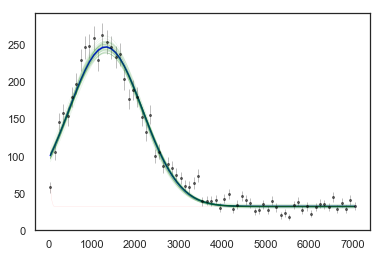

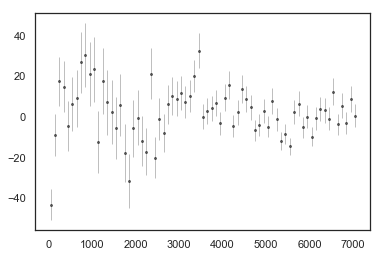

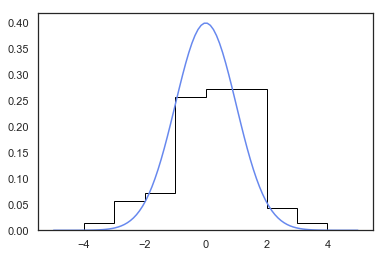

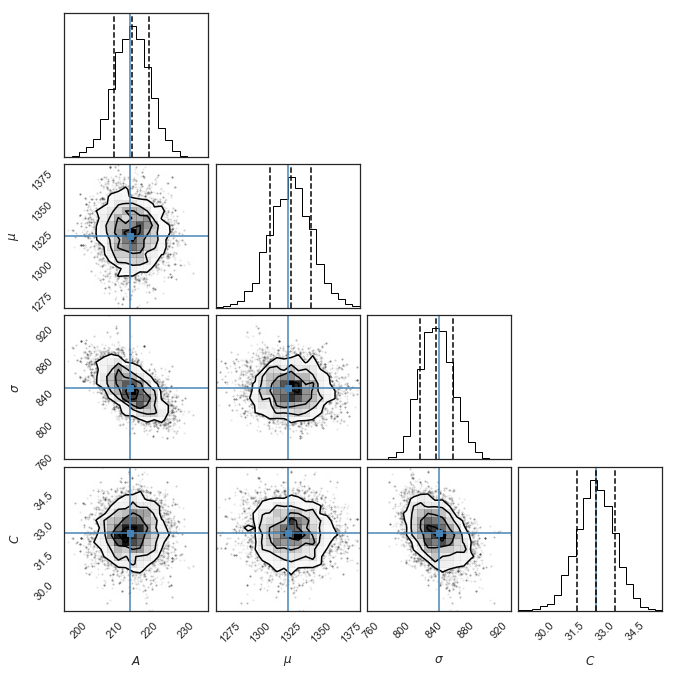

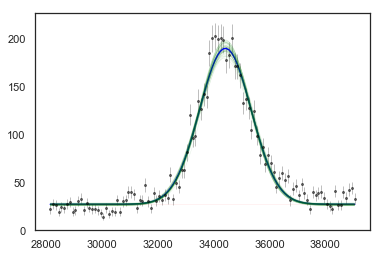

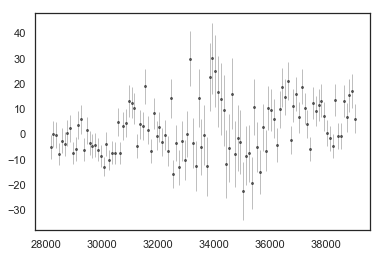

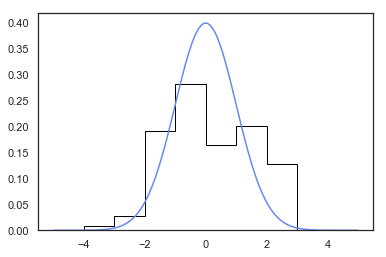

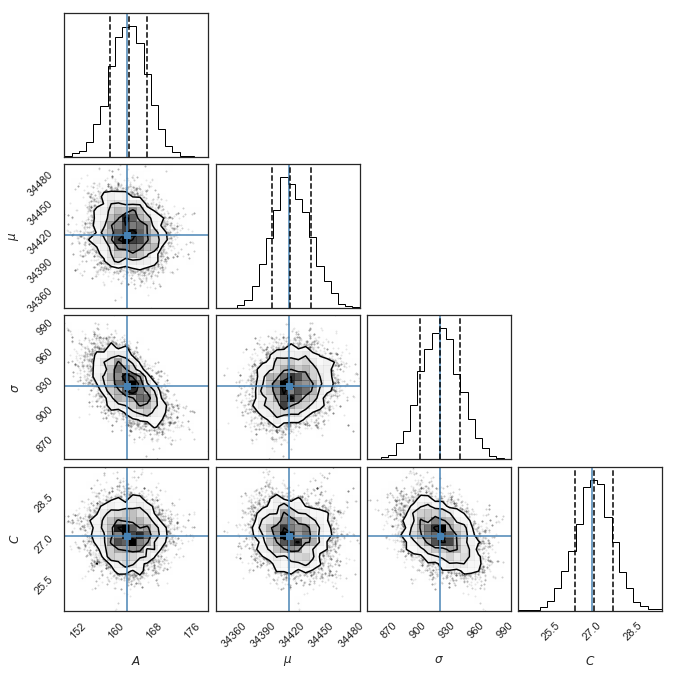

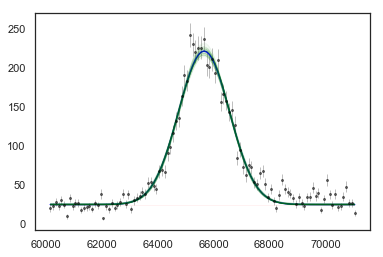

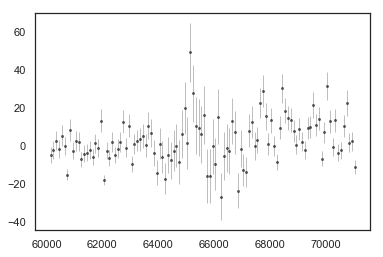

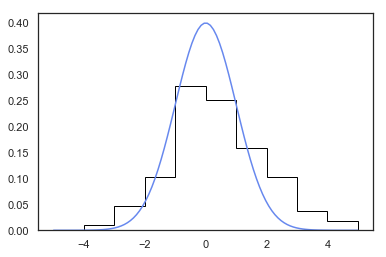

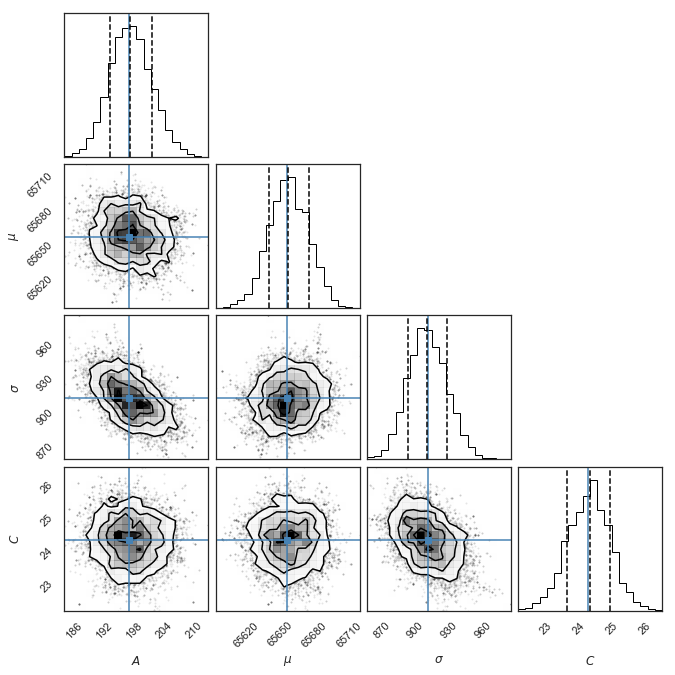

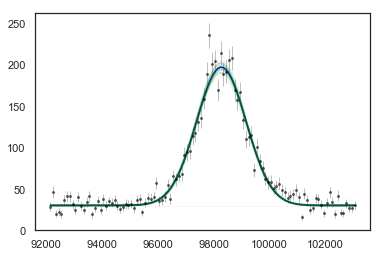

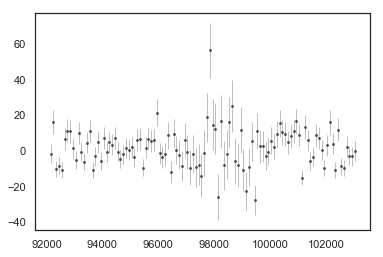

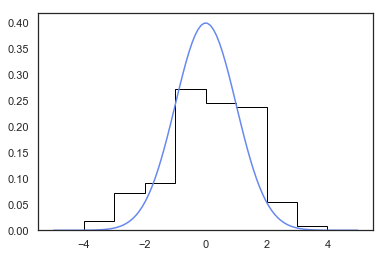

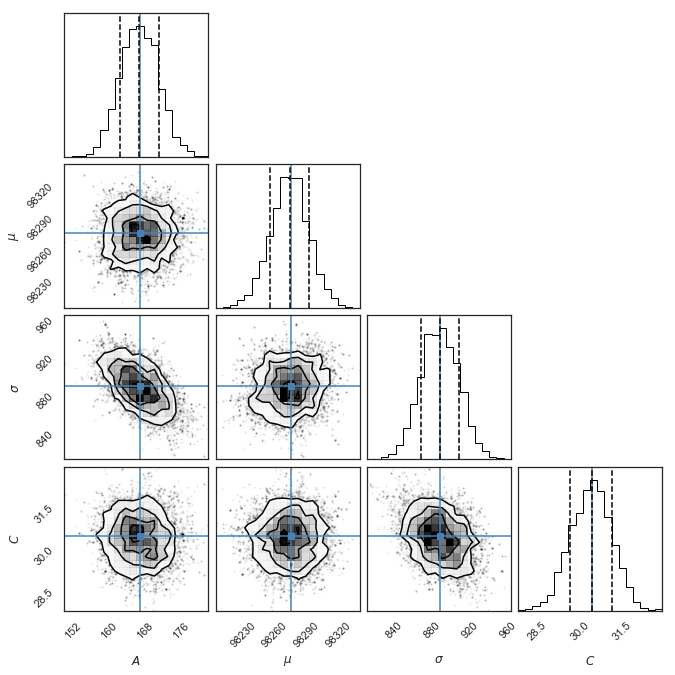

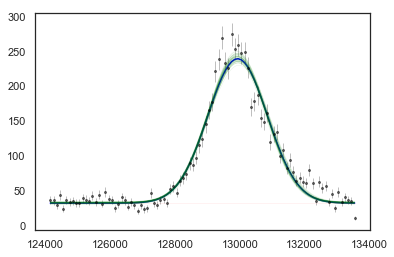

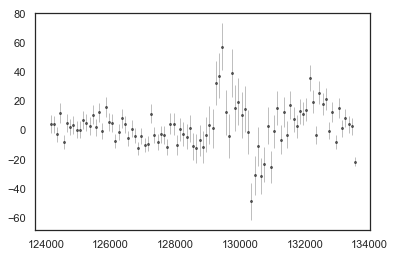

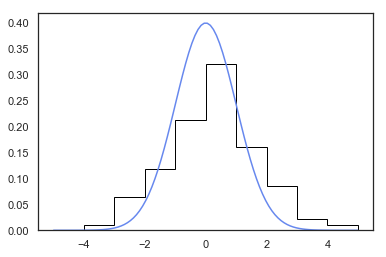

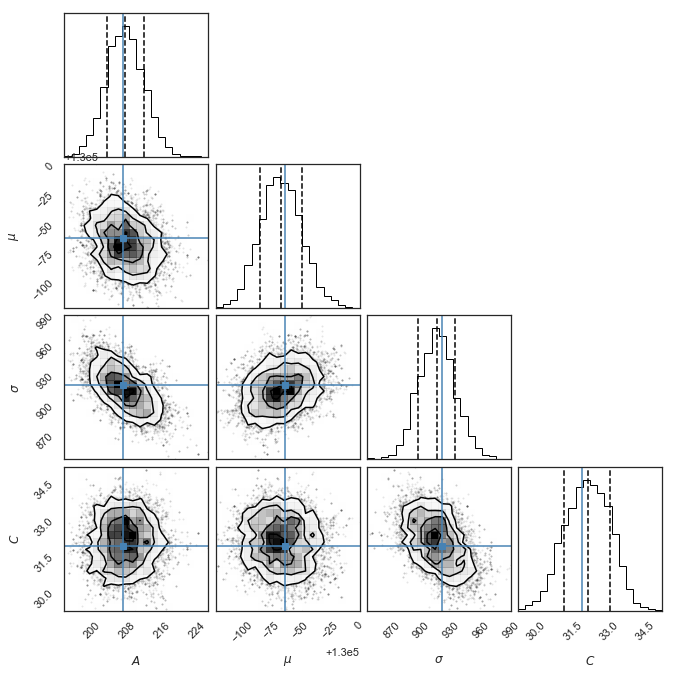

In [70]:
res = fit_gauss_all(tbin,ybin,sbin)

### Now do it with GP

<font color=red>To use GP need to first fit without GP, model residuals with GP to initialise HPs, then do joint fit.</font>

[ 200.         1600.          780.           35.412725      4.60517019
    0.        ]


Orbit: 1
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                      1293.4 28139395691351920.0  -427936.1 + 87945503659.3 - 19312643607015.1
loc                      1088.4 -96547879806389440.0   910435.6 + 66267093233781.4 - 301899017699.9
half-width               1581.4 -173255181165620352.0  2100900.3 + 118912802566160.5 - 541639316991.3
DC                      -1003.7 -24092538707959568.0   389774.6 + 16535051474884.6 - 75292539540.4
log_var                     9.6        9.9       10.7 +        2.5 -        1.4
log_metric                  5.8        6.0        6.4 +        0.5 -        0.7


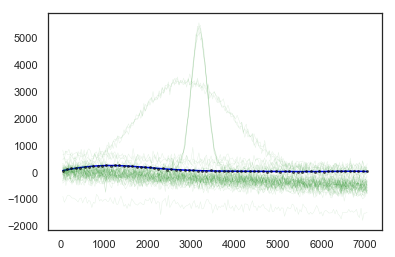

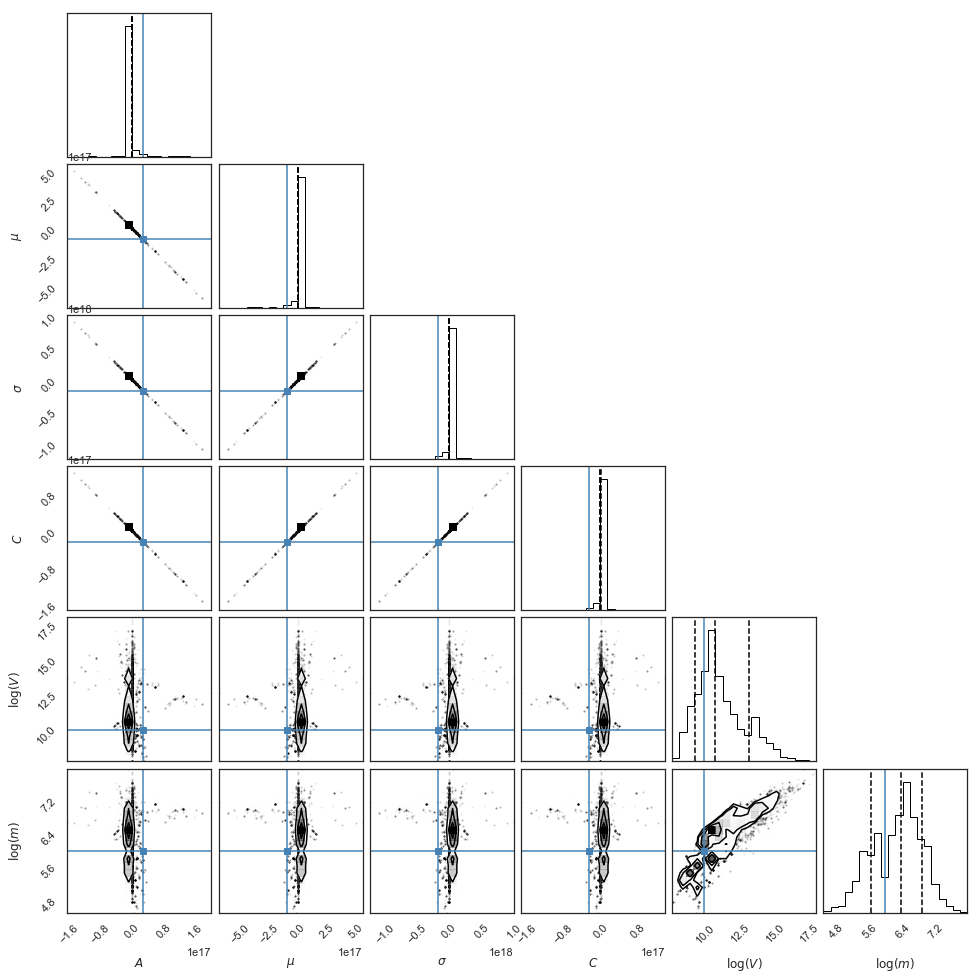

In [51]:
res = fit_gauss_all(tbin,ybin,sbin,use_gp=True)

### So which parameters vary from pulse to pulse and how much?

#### <font color=red>TBD: fit ephemeris properly:</font>
- <font color=red>accounting for individual uncertainties on individual times</font>
- <font color=red>using one period for all pulses but different offsets for odd and even</font>
- <font color=red>computing uncertainties on ephemeris parameters</font>

In [ ]:
orbit, amp_fit, mu_fit, sig_fit, dc_fit, amp_err, mu_err, sig_err, dc_err = res
fig,axes = plt.subplots(5,1,figsize=(10,10),sharex =True)
axes[0].errorbar(orbit,amp_fit,yerr=amp_err,fmt='.')
axes[1].errorbar(orbit,mu_fit,yerr=mu_err,fmt='.')
orb = np.array(orbit)
mus = np.array(mu_fit)
mue = np.array(mu_err)
l_odd = (orb%2)==1
print(l_odd)
l_even = ~l_odd
print(l_even)
p_odd = np.polyfit(orb[l_odd],mus[l_odd],1)
v_odd = np.polyval(p_odd,orb[l_odd])
print(p_odd)
p_even = np.polyfit(orb[l_even],mus[l_even],1)
print(p_even)
v_even = np.polyval(p_even,orb[l_even])
p_even = np.polyfit(np.array(orbit)[1::2],np.array(mu_fit)[1::2],1)
axes[2].errorbar(orb[l_odd],mus[l_odd]-v_odd,yerr=mue[l_odd],fmt='.',color='r')
axes[2].errorbar(orb[l_even],mus[l_even]-v_even,yerr=mue[l_even],fmt='.',color='b')
axes[3].errorbar(orbit,sig_fit,yerr=sig_err,fmt='.')
axes[4].errorbar(orbit,dc_fit,yerr=dc_err,fmt='.')
axes[0].set_ylabel('amplitude')
axes[1].set_ylabel('position')
axes[2].set_ylabel('O-C')
axes[3].set_ylabel('half-width')
axes[4].set_ylabel('dc level')
axes[4].set_xlabel('orbit number')


### In case I accidentally delete cells containing important functions again...

In [ ]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))